# Phase 1a - Training of 9 Neural Networks (U-Nets)

Code framework from 
https://www.depends-on-the-definition.com/unet-keras-segmenting-images/ re-used and customised for the purposes of this project

In [1]:
import os
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import MRASegmentation as mra
import unets.UNetModels as un
import utils.support as sup

from keras.callbacks import EarlyStopping, ModelCheckpoint 

/Users/rvh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


No MRA scans are available and nothing can be processed. Set up source data in directory data/source/


We start by creating an instance for the MRA blood vessel segmentation process. Then we read in all the MRA Record ids for the provided cerebral MRA scans. 

In [2]:
app = mra.MRASegmentation()
mra_all = app.get_mra_source_ids()

In the first step we create 9 image projections and corresponding projections of ground truth data for all 10 patient records that have been made available for this project.
IMPORTANT: SET DEBUG=Yes in the ini-file, as data stored in this directory will be used by the training processes of the nine neural networks (UNETS). 1 UNET is trained for each image projection. 

In [3]:
if not app._debug: 
    print ("Set the debug parameter to YES, prior to proceeding with this notebook")
    raise ValueError
else: 
    app.set_up_debug_directories (mra_all)
    for nme in mra_all:  
        app._mra_id = nme
        src = app.get_3d_mra_source(nme) 
        app.get_2d_mra_src_projs(src)
        gt = app.get_3d_mra_gt(nme)
        app.get_2d_mra_gt_projs(gt)
        print('Record '+nme+' processed successfully.') 

Record MNI_0656 processed successfully.
Record MNI_0657 processed successfully.
Record MNI_0592 processed successfully.
Record MNI_0643 processed successfully.
Record MNI_0663 processed successfully.
Record MNI_0664 processed successfully.
Record MNI_0590 processed successfully.
Record MNI_0591 processed successfully.
Record MNI_0640 processed successfully.
Record MNI_0648 processed successfully.


Split into training, validation and test data sets

In [4]:
mra_val = ['MNI_0656']   # the manually segmented record is used as validation record during training 
mra_trn = app.get_mra_source_ids()
mra_trn.remove('MNI_0656') # traning data set does not include the manually segmented record
mra_trn.remove('MNI_0663') # removed as MNI_0663 is not used during training (only during final testing in Phase 3)

Create an instance for the nine U-Nets

In [6]:
unets = un.MRA_UNets(app._model_path,
                    app._no_slices,
                    app._img_height,
                    app._img_width,
                    app.NO_PROJECTIONS,
                    app._unet_threshold)


# store the results of each training run in a dictionary for printing and further analysis 
results = dict() 


print('CAUTION: Any existing model coefficients in model path '+app._model_path+' will be overwritten if you proceed!!!')

The following process completes training for each of the nine projections in 10 - 15min on commodity hardware (MacBook Air, 8GB RAM). On this hardware, the entire training process completes in 2hours 30min. No GPU accelerations have been utilised. 

Important note: if you plan to start a clean new run, you should remove all the weightings for the neural networks in the 'models' folder. Otherwise, the process will run the weightings from the previous run and attempt to improve the model from there. 

In [8]:
for i in range(app.NO_PROJECTIONS):  
    projection = str(i+1)
    print('********************************************')
    print('TRAINING NEURAL NETWORK FOR PROJECTION '+projection+'...')
    print('********************************************')
    # get padded image dimensions that should be used in neural network 
    h, w = unets.get_image_projection_size (projection)
 
    # Load the training data 
    src_trn = np.zeros((len(mra_trn), h, w, 1), dtype=np.float32) 
    gt_trn  = np.zeros((len(mra_trn), h, w, 1), dtype=np.float32) 
    j=0
    for f in mra_trn: 
        img = cv2.imread(app._debug_path + f +'/Step2 2D-Source-Projection-' + projection + '-CLAHE.jpg')
        ho, wo = unets.get_image_size (projection)
        x_img = sup.convert_image_to_grey(img,ho,wo)
        src_trn[j,:ho,:wo,0] = x_img / 255.0
        
        img = cv2.imread(app._debug_path + f +'/Step2 2D-GT-Projection-' + projection + '.jpg')
        ho, wo = unets.get_image_size (projection)
        x_img = sup.convert_image_to_grey(img,ho,wo)
        gt_trn[j,:ho,:wo,0] = x_img / 255.0
        j = j+1

    # Load the validation data 
    src_val = np.zeros((len(mra_val), h, w, 1), dtype=np.float32) 
    gt_val  = np.zeros((len(mra_val), h, w, 1), dtype=np.float32) 
    j=0
    for f in mra_val: 
        img = cv2.imread(app._debug_path + f +'/Step2 2D-Source-Projection-' + projection + '-CLAHE.jpg')
        ho, wo = unets.get_image_size (projection)
        x_img = sup.convert_image_to_grey(img,ho,wo)
        src_val[j,:ho,:wo,0] = x_img / 255.0
        
        img = cv2.imread(app._debug_path + f +'/Step2 2D-GT-Projection-' + projection + '.jpg')
        ho, wo = unets.get_image_size (projection)
        x_img = sup.convert_image_to_grey(img,ho,wo)
        gt_val[j,:ho,:wo,0] = x_img / 255.0
        j = j+1

    # initialise the U-Net for the p-th projection before starting the training run 
    model = unets.load_model(projection)
    model_par_file = app._model_path+'model-Projection-'+projection 
    # model.summary() if you want to display the summary of the UNET model 
    callbacks = [EarlyStopping(patience=10, verbose=1),
         ModelCheckpoint(model_par_file, verbose=1, save_best_only=True, save_weights_only=True)]
    # now start the training process for the p-th projection: 
    results[projection] = model.fit(src_trn, gt_trn, batch_size=1, epochs=50, callbacks=callbacks,
                    validation_data=(src_val, gt_val))
    

********************************************
TRAINING NEURAL NETWORK FOR PROJECTION 1...
********************************************
Train on 8 samples, validate on 1 samples
Epoch 1/50
8/8 [==============================] - 17s 2s/step - loss: 0.1014 - binary_accuracy: 0.8669 - val_loss: 0.1259 - val_binary_accuracy: 0.8860

Epoch 00001: val_loss improved from inf to 0.12585, saving model to data/models-3/model-Projection-1
Epoch 2/50
8/8 [==============================] - 14s 2s/step - loss: 0.0953 - binary_accuracy: 0.8675 - val_loss: 0.1290 - val_binary_accuracy: 0.8890

Epoch 00002: val_loss did not improve from 0.12585
Epoch 3/50
8/8 [==============================] - 13s 2s/step - loss: 0.0894 - binary_accuracy: 0.8683 - val_loss: 0.1263 - val_binary_accuracy: 0.8881

Epoch 00003: val_loss did not improve from 0.12585
Epoch 4/50
8/8 [==============================] - 14s 2s/step - loss: 0.0838 - binary_accuracy: 0.8691 - val_loss: 0.1561 - val_binary_accuracy: 0.8802

Epoch 000

Epoch 3/50
8/8 [==============================] - 12s 2s/step - loss: 0.1713 - binary_accuracy: 0.8205 - val_loss: 0.1655 - val_binary_accuracy: 0.8581

Epoch 00003: val_loss improved from 0.18500 to 0.16550, saving model to data/models-3/model-Projection-3
Epoch 4/50
8/8 [==============================] - 11s 1s/step - loss: 0.1630 - binary_accuracy: 0.8211 - val_loss: 0.1691 - val_binary_accuracy: 0.8559

Epoch 00004: val_loss did not improve from 0.16550
Epoch 5/50
8/8 [==============================] - 11s 1s/step - loss: 0.1558 - binary_accuracy: 0.8215 - val_loss: 0.1689 - val_binary_accuracy: 0.8518

Epoch 00005: val_loss did not improve from 0.16550
Epoch 6/50
8/8 [==============================] - 11s 1s/step - loss: 0.1499 - binary_accuracy: 0.8217 - val_loss: 0.1987 - val_binary_accuracy: 0.8338

Epoch 00006: val_loss did not improve from 0.16550
Epoch 7/50
8/8 [==============================] - 11s 1s/step - loss: 0.1430 - binary_accuracy: 0.8230 - val_loss: 0.1829 - val_bi

8/8 [==============================] - 22s 3s/step - loss: 0.0769 - binary_accuracy: 0.8850 - val_loss: 0.0902 - val_binary_accuracy: 0.9106

Epoch 00017: val_loss did not improve from 0.08661
Epoch 18/50
8/8 [==============================] - 22s 3s/step - loss: 0.0750 - binary_accuracy: 0.8853 - val_loss: 0.0853 - val_binary_accuracy: 0.9119

Epoch 00018: val_loss improved from 0.08661 to 0.08526, saving model to data/models-3/model-Projection-4
Epoch 19/50
8/8 [==============================] - 22s 3s/step - loss: 0.0742 - binary_accuracy: 0.8852 - val_loss: 0.0891 - val_binary_accuracy: 0.9095

Epoch 00019: val_loss did not improve from 0.08526
Epoch 20/50
8/8 [==============================] - 23s 3s/step - loss: 0.0716 - binary_accuracy: 0.8858 - val_loss: 0.1009 - val_binary_accuracy: 0.9071

Epoch 00020: val_loss did not improve from 0.08526
Epoch 21/50
8/8 [==============================] - 23s 3s/step - loss: 0.0698 - binary_accuracy: 0.8863 - val_loss: 0.1023 - val_binary_ac


Epoch 00018: val_loss did not improve from 0.07935
Epoch 19/50
8/8 [==============================] - 22s 3s/step - loss: 0.0741 - binary_accuracy: 0.8857 - val_loss: 0.1056 - val_binary_accuracy: 0.9028

Epoch 00019: val_loss did not improve from 0.07935
Epoch 20/50
8/8 [==============================] - 23s 3s/step - loss: 0.0728 - binary_accuracy: 0.8860 - val_loss: 0.0871 - val_binary_accuracy: 0.9077

Epoch 00020: val_loss did not improve from 0.07935
Epoch 21/50
8/8 [==============================] - 23s 3s/step - loss: 0.0726 - binary_accuracy: 0.8857 - val_loss: 0.0792 - val_binary_accuracy: 0.9109

Epoch 00021: val_loss improved from 0.07935 to 0.07916, saving model to data/models-3/model-Projection-5
Epoch 22/50
8/8 [==============================] - 24s 3s/step - loss: 0.0723 - binary_accuracy: 0.8857 - val_loss: 0.0841 - val_binary_accuracy: 0.9075

Epoch 00022: val_loss did not improve from 0.07916
Epoch 23/50
8/8 [==============================] - 24s 3s/step - loss: 0.0


Epoch 00019: val_loss did not improve from 0.14351
Epoch 20/50
8/8 [==============================] - 28s 4s/step - loss: 0.0786 - binary_accuracy: 0.8959 - val_loss: 0.1192 - val_binary_accuracy: 0.9073

Epoch 00020: val_loss improved from 0.14351 to 0.11918, saving model to data/models-3/model-Projection-6
Epoch 21/50
8/8 [==============================] - 28s 4s/step - loss: 0.0749 - binary_accuracy: 0.8965 - val_loss: 0.1442 - val_binary_accuracy: 0.9016

Epoch 00021: val_loss did not improve from 0.11918
Epoch 22/50
8/8 [==============================] - 28s 4s/step - loss: 0.0729 - binary_accuracy: 0.8968 - val_loss: 0.1775 - val_binary_accuracy: 0.8921

Epoch 00022: val_loss did not improve from 0.11918
Epoch 23/50
8/8 [==============================] - 28s 4s/step - loss: 0.0708 - binary_accuracy: 0.8970 - val_loss: 0.1357 - val_binary_accuracy: 0.9008

Epoch 00023: val_loss did not improve from 0.11918
Epoch 24/50
8/8 [==============================] - 28s 3s/step - loss: 0.0


Epoch 00011: val_loss did not improve from 0.07233
Epoch 12/50
8/8 [==============================] - 24s 3s/step - loss: 0.0675 - binary_accuracy: 0.9025 - val_loss: 0.0820 - val_binary_accuracy: 0.9231

Epoch 00012: val_loss did not improve from 0.07233
Epoch 13/50
8/8 [==============================] - 24s 3s/step - loss: 0.0657 - binary_accuracy: 0.9028 - val_loss: 0.0718 - val_binary_accuracy: 0.9271

Epoch 00013: val_loss improved from 0.07233 to 0.07183, saving model to data/models-3/model-Projection-8
Epoch 14/50
8/8 [==============================] - 10496s 1312s/step - loss: 0.0650 - binary_accuracy: 0.9027 - val_loss: 0.0856 - val_binary_accuracy: 0.9215

Epoch 00014: val_loss did not improve from 0.07183
Epoch 15/50
8/8 [==============================] - 25s 3s/step - loss: 0.0627 - binary_accuracy: 0.9031 - val_loss: 0.0946 - val_binary_accuracy: 0.9195

Epoch 00015: val_loss did not improve from 0.07183
Epoch 16/50
8/8 [==============================] - 22s 3s/step - los

Display results of learning curves for each of the nine projections

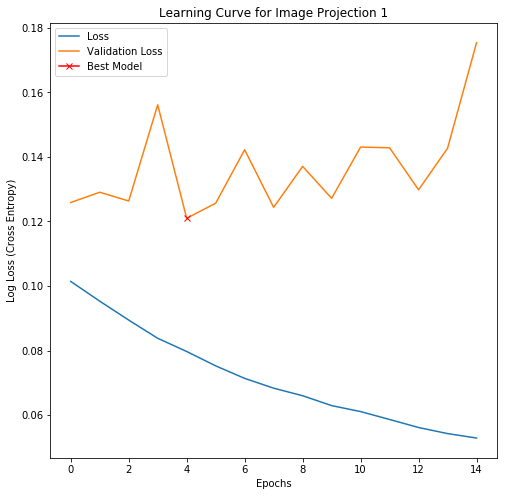

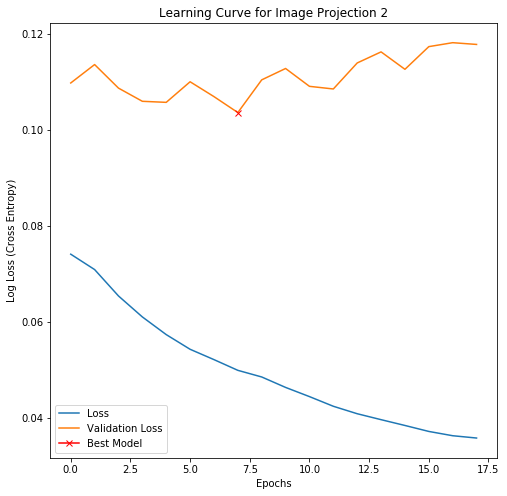

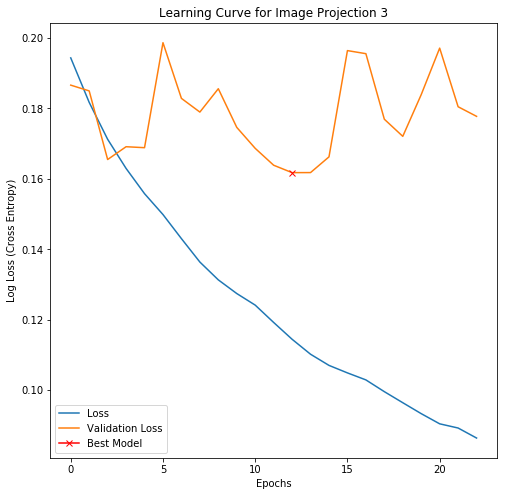

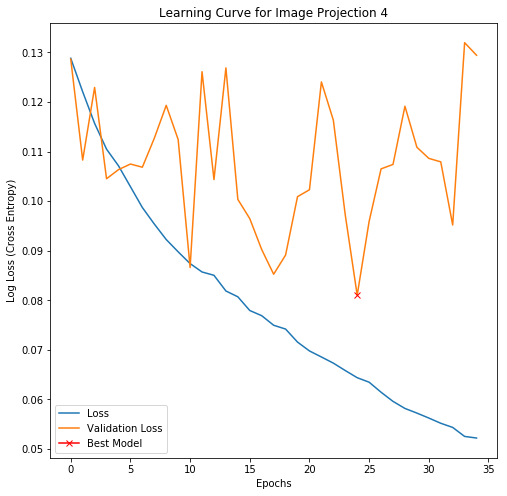

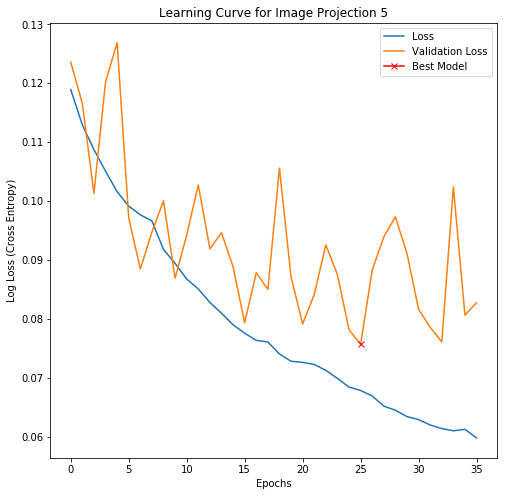

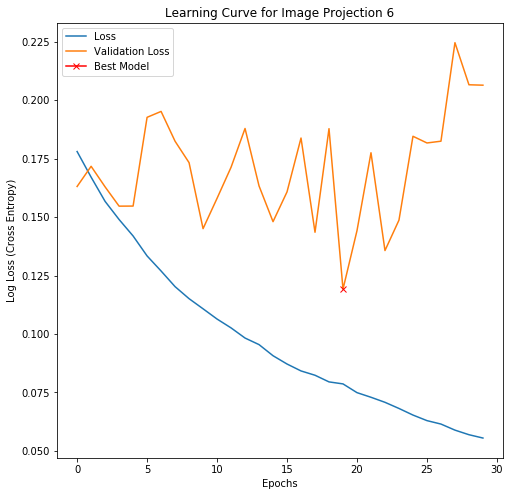

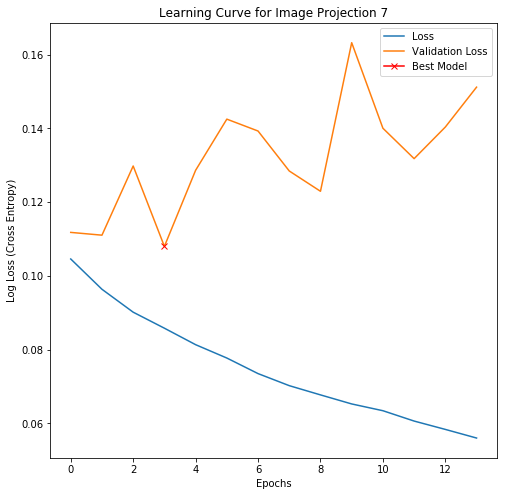

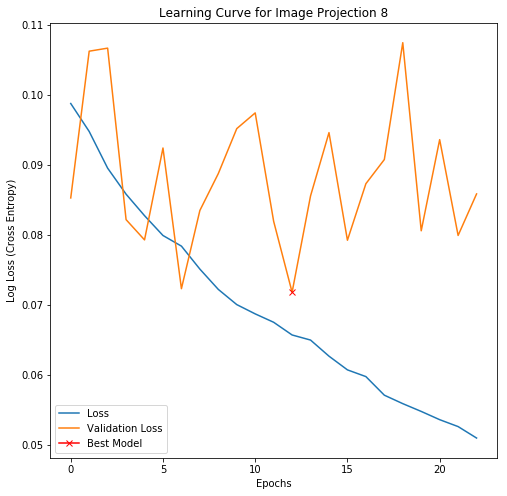

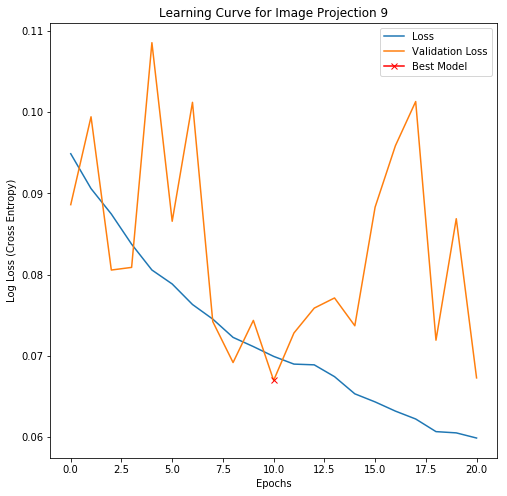

In [9]:
for i in range(app.NO_PROJECTIONS):
    projection = str(i+1)
    res = results[projection]
    plt.figure(figsize=(8, 8))
    plt.title("Learning Curve for Image Projection "+projection)
    plt.plot(res.history["loss"], label="Loss")
    plt.plot(res.history["val_loss"], label="Validation Loss")
    plt.plot( np.argmin(res.history["val_loss"]), np.min(res.history["val_loss"]), marker="x", color="r", label="Best Model")
    plt.xlabel("Epochs")
    plt.ylabel("Log Loss (Cross Entropy)")
    plt.legend();

End of Training Process